In this tutorial we will model quantum models as Fourier sums.

A paper from Maria Schuld et al. [1] shows how a quantum model as such:

![./Fourier_Circuit_MS.png](Fourier_Circuit_MS.png)


can be written as a Fourier-type sum of the form:

$f_θ(x)=\sum_{ω∈Ω}c_ω(θ)e^{iωx}$

The data encoding circuit blocks (denoted S(x)) determine the set Ω of available “frequencies”, and the remainder of the circuit, including the trainable parameters (denoted W(theta)), determines the coefficients $c_ω$.

In [1]:
!pip install pennylane # comment if pennylane is already installed
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import StronglyEntanglingLayers

np.random.seed(0)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


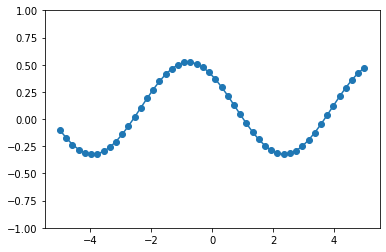

In [2]:
# Creating the function the quantum model has to learn

# degree of the target Fourier function
degree = 1

# coefficients of non-zero frequencies
coeffs = [0.15 + 0.15j] * degree

# coefficient of zero frequency
coeff0 = 0.1  

def target_function(x):
    # This is a helper to create a function that the quantum
    # model has to fit using the Fourier series (the ground truth)
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128((idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

# And now to plot the target function
x = np.linspace(-5, 5, 50, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y)
plt.scatter(x, target_y)
plt.ylim(-1, 1)
plt.show()

We will have two quantum models.
The first and simpler quantum model is the following circuit:

![./simple_circuit_fourier.png](simple_circuit_fourier.png)

You can see the concept of data reuploading present in the circuit, considering the repetition of a data encoding layer after all trainable layers (apart from the last one).

In [3]:
# Now we define the quantum model that will learn the function we defined above

dev = qml.device("default.qubit", wires=1) # TODO: Instantiate the default pennylane device

def data_encoding_layer(x):
    # TODO: Define the data encoding as a parametrized RX gate
    qml.RX(x, wires=0)

def trainable_layer(theta):
    # TODO: Define the trainable layer as a general 3-parameters rotational gate
    qml.Rot(theta[0], theta[1], theta[2], wires=0)
    
@qml.qnode(dev)
def quantum_model(weights, x):
    # TODO: create the quantum model
    for theta in weights[:-1]:
        trainable_layer(theta)
        data_encoding_layer(x)
        
    trainable_layer(weights[-1])
        
    # TODO: return the expectation value
    # with respect to the Z observable
    return qml.expval(qml.PauliZ(0))

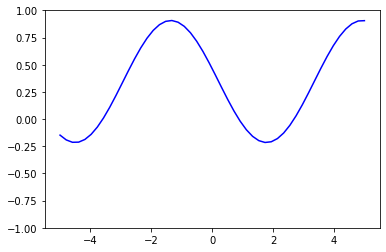

In [4]:
layers = 1
weights = 2 * np.pi * np.random.random(size=(layers+1, 3), requires_grad=True)

x = np.linspace(-5, 5, 50, requires_grad=False)
random_quantum_model_y = [quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

In [5]:
# TODO: print the circuit to check it is well defined
qml.draw(quantum_model)(weights, x[0])

'0: ──Rot(3.45,4.49,3.79)──RX(-5.00)──Rot(3.42,2.66,4.06)─┤  <Z>'

In [6]:
def square_loss(targets, preds):
    loss = 0
    # TODO: compute the square loss between the ground
    # truth values (targets) and what our model obtained (predictions)
    for i in range(len(targets)):
        loss += (targets[i] - preds[i])**2
    return 0.5 * loss

def cost(weights, x, y):
    preds = [quantum_model(weights, x_) for x_ in x]
    return square_loss(y, preds)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 20
cst = [cost(weights, x, target_y)]  # initial cost
for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)
    
    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.16050370648735188
Cost at step  20: 0.025434950197603834
Cost at step  30: 0.04151355007948233
Cost at step  40: 0.02414210467798878
Cost at step  50: 0.011803642238386645


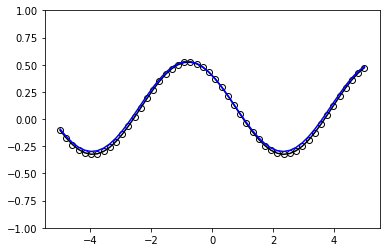

In [7]:
predictions = [quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show()

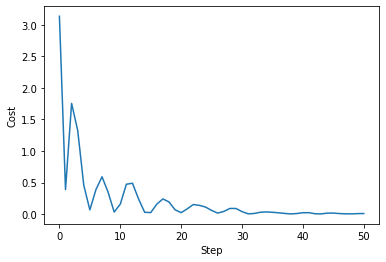

In [8]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.show()

Now we will work on the same task using a more complex and parallel model.

![./parallel_circuit.png](parallel_circuit.png)

In [10]:
n_ansatz_layers = 2
n_qubits = 3
r = 3

def data_encoding_layer(x):
    # TODO: apply an RX gate on each qubit
    for w in range(r):
        qml.RX(x, wires=w)

def trainable_layer(theta):
    # TODO: apply pennylane's strongly entangling layer
    StronglyEntanglingLayers(theta, wires=range(r))

# TODO: Instantiate the qiskit default device
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)
def parallel_quantum_model(weights, x):

    trainable_layer(weights[0])
    data_encoding_layer(x)
    trainable_layer(weights[1])

    # TODO: measure the expectation value of the 
    # Z measurement of the first qubit
    return qml.expval(qml.PauliZ(wires=0)) 

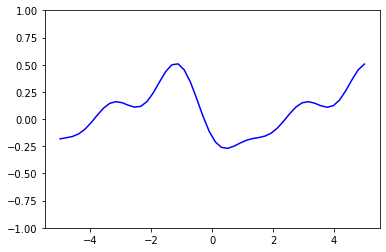

In [11]:
trainable_block_layers = 2
weights = 2 * np.pi * np.random.random(size=(2, trainable_block_layers, n_qubits, 3), requires_grad=True)

x = np.linspace(-5, 5, 50, requires_grad=False)
random_quantum_model_y = [parallel_quantum_model(weights, x_) for x_ in x]

# We can plot to see how the function currently looks like
plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show();

Cost at step  10: 2.5202260837158788
Cost at step  20: 0.31915247935846375
Cost at step  30: 0.17803003446336063
Cost at step  40: 0.11875903005226979
Cost at step  50: 0.07524515986197416


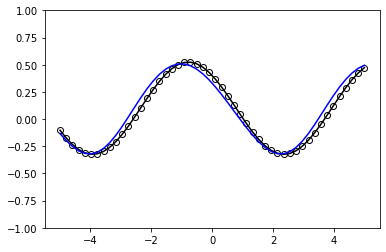

In [12]:
# We need to reach the same target function as before
def cost(weights, x, y):
    predictions = [parallel_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 20
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

predictions = [parallel_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show()

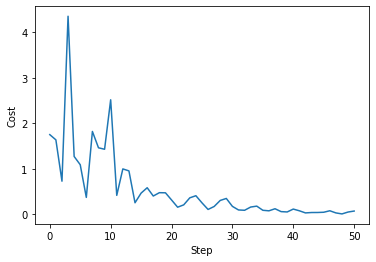

In [13]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.show()

Tutorial based on:

[1] "The effect of data encoding on the expressive power of variational quantum machine learning models" by Schuld, Sweke, and Meyer https://arxiv.org/abs/2008.08605

